## Dog v/s Cat Classifier

You can use this notebook to train our dog v/s cat classifier. FastAI makes it super easy to train the models too, under 10 lines of code we have a descent classifier!

In [1]:
from fastai.vision.all import *
from pathlib import Path

In [2]:
path = untar_data(URLs.PETS)
path.ls()

(#5) [Path('/home/jithin/.fastai/data/oxford-iiit-pet/annotations'),Path('/home/jithin/.fastai/data/oxford-iiit-pet/model.pkl'),Path('/home/jithin/.fastai/data/oxford-iiit-pet/export.pkl'),Path('/home/jithin/.fastai/data/oxford-iiit-pet/learner.pkl'),Path('/home/jithin/.fastai/data/oxford-iiit-pet/images')]

In [3]:
files = get_image_files(path/"images")
len(files)

7390

In [4]:
from dogvscat_utils import label_func

dls = ImageDataLoaders.from_name_func(path, files, 
                                      label_func, 
                                      item_tfms=Resize(224))

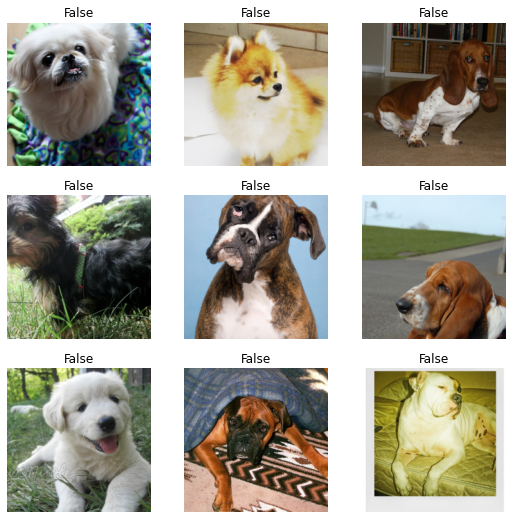

In [5]:
dls.show_batch()

As you can see we have the images ready to be loaded for training. We are going to use a resnet34 and finetune on top of that. Lets see what how it goes

In [6]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.136679,0.029212,0.011502,00:17


epoch,train_loss,valid_loss,error_rate,time
0,0.051465,0.024289,0.008796,00:21
1,0.023272,0.016052,0.004736,00:21


In [7]:
learn.predict(files[0])

('False', tensor(0), tensor([0.9931, 0.0069]))

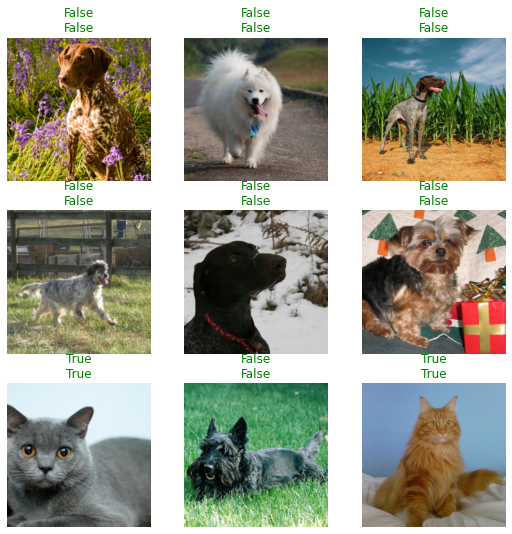

In [9]:
learn.show_results()

With just 2 epoch of training we have created a fairly descent classifier for dogs and cats, good on ya mate!

Now lets save it and generate the final model file. 

In [10]:
p = learn.path
path

Path('/home/jithin/.fastai/data/oxford-iiit-pet')

In [11]:
learn.export('model.pkl')
print('Saved to: ', learn.path)

Saved to:  /home/jithin/.fastai/data/oxford-iiit-pet


FastAI library usually saves the model in the `learn.path` folder. We will copy if from there to our CWD. 

In [13]:
from shutil import copyfile
copyfile(learn.path/'model.pkl', 'model.pkl')

'model.pkl'

## Inference
Now lets figure out the about loading the models and running the inference. 

In [14]:
os.listdir('images/')

['c1.jpg', 'd2.jpg', 'c2.jpg', 'd3.jpg', 'c3.jpg', 'd1.jpg']

In [15]:
from dogvscat_utils import label_func

loaded_learner = load_learner('model.pkl')

In [16]:
files = get_image_files('images')
dl = loaded_learner.dls.test_dl(files)
dl

In [17]:
files

(#6) [Path('images/c1.jpg'),Path('images/d2.jpg'),Path('images/c2.jpg'),Path('images/d3.jpg'),Path('images/c3.jpg'),Path('images/d1.jpg')]

In [18]:
loaded_learner.get_preds(dl=dl)

(tensor([[1.8513e-08, 1.0000e+00],
         [9.9980e-01, 2.0502e-04],
         [4.3528e-12, 1.0000e+00],
         [9.9998e-01, 2.0696e-05],
         [4.2210e-16, 1.0000e+00],
         [1.0000e+00, 1.9188e-06]]),
 None)

In [19]:
from bentoservice import DogVCatService

svc = DogVCatService()
svc.pack('learner', loaded_learner)
svc.save_to_dir('bento_service/')

[2021-01-30 12:16:18,518] WARNING - BentoML by default does not include spacy and torchvision package when using FastaiModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_packages=['torchvision'])` when defining a BentoService
[2021-01-30 12:16:20,274] INFO - BentoService bundle 'DogVCatService:20210130121618_234C80' created at: bento_service/
